# I.I.D Return Model  

Assume that the asset price follow the Black-Scholes Model:
$\frac{dS_t}{S_t} = (r\mathbf{1} + \Sigma\lambda)dt + \Sigma dZ_t$

Then excess stock return given by $ R_k = \exp\left((r \cdot \mathbf{1} + \Sigma\lambda - \frac{1}{2}\text{diag}(\Sigma \cdot \Sigma^T)) \Delta + \sqrt{\Delta} \Sigma \epsilon_k\right) - R_f \mathbf{1} $, where $ \epsilon_t $ follows a multivariate normal distribution $ N_p(\mathbf{0}, I_p) $

$s_k = W_k$, $\eta_k = R_k$, $W_{k+1} = W_k(g_k^TR_k + R_f)$, and $s_{k+1} = W_{k+1}$

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor

class UtilityLoss(torch.nn.Module):
    def __init__(self):
        super(UtilityLoss, self).__init__()

    def forward(self, W, gamma):
        objective = - (W - gamma/2)**2
        return -objective.mean()
    
class PortfolioModel(nn.Module):
    def __init__(self, r, P, cov, Lambda, Delta, K, lb, ub,Rf,batch_size):
        super(PortfolioModel, self).__init__()
        self.K = K
        self.Rf = Rf
        self.batch_size = batch_size
        self.stack_layers = nn.ModuleList()
        for i in range(K):
            self.stack_layers.append(StackLayer(r, P, cov, Lambda, Delta, K, lb, ub,Rf,batch_size))
    
    def forward(self,inputs):
#         print('initial portfolio wealth: 1')
        for i in range(self.K):
#             print('subnetwork {}'.format(i))
            inputs = self.stack_layers[i](inputs)
#             if i == 1:
#                 score = (inputs.detach().numpy().mean()*np.exp(0.03/40)**-1 - 2)**2
#                 return score
        return inputs

class Subnetwork(nn.Module):
    def __init__(self, r, P, cov, Lambda, Delta, K, lb, ub,Rf, batch_size):
        super(Subnetwork, self).__init__()
        self.Rf = Rf
        self.lb = lb
        self.ub = ub
        epsilon = np.random.multivariate_normal(mean=np.zeros(int(P)), cov=np.eye(int(P))) 
        self.R = np.zeros((batch_size, P))
        for b in range(batch_size):          
                epsilon = np.random.multivariate_normal(mean=np.zeros(P), cov=np.eye(P))
                self.R[b, :] = np.exp((r * np.ones(P) + cov @ Lambda - (1/2) * np.diag(cov @ cov.T)) * Delta +
                    np.sqrt(Delta) * cov @ epsilon) - Rf * np.ones(P)
        self.R = torch.Tensor(self.R)
        self.subnetwork = nn.Sequential(
            nn.Linear(5, 50, bias=False),
            nn.Tanh(),
            nn.Linear(50, 50, bias=False),
            nn.Tanh(),
            nn.Linear(50, 50, bias=False),
            nn.Tanh(),
            nn.Linear(50, 50, bias=False),
            nn.Tanh(),
            nn.Linear(50, 5, bias=False),
            nn.Tanh(),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        state_variable = x 
        out = self.R 
        weights = self.subnetwork(out)
#         print("weights before rebalancing:", weights.detach().numpy())
        
        output = torch.stack([self.rebalance(batch, self.lb, self.ub) for batch in weights])
#         print('weights after rebalancing',output.detach().numpy())
#         print('self.R', self.R.shape)
#         print('self.Rf',self.Rf.shape)

        updated_state_variable = torch.stack([torch.sum(state_variable[i] * output[i] * (1+self.R[i])* self.Rf) for i in range(output.shape[0])])
#         print('returns',self.R+1)
#         print('Rf',self.Rf)
#         print(((output * (self.R + Rf)).sum())
#         print('new portfolio wealth:', updated_state_variable.detach().numpy())
        return updated_state_variable 

    def rebalance(self, weight, lb, ub):
        old = weight
        new = torch.clamp(old, lb, ub)
        while True:
            leftover = (old - new).sum()
            other_stocks = new[torch.where(new != ub)[0]]
            reassign = leftover * (other_stocks/other_stocks.sum())
            new[torch.where(new != ub)[0]] += reassign 
            old = new
            if len(torch.where(new > ub)[0]) == 0:
                break
            else:
                new = torch.clamp(old, lb, ub)
        return new
    
class StackLayer(nn.Module):
    def __init__(self, r, P, cov, Lambda, Delta, K, lb, ub,Rf,batch_size):
        super(StackLayer, self).__init__()
        self.blocks = nn.ModuleList([Subnetwork(r, P, cov, Lambda, Delta, K, lb, ub,Rf,batch_size)])   
    def forward(self, inputs):
        outputs = inputs 
        for block in self.blocks:
            outputs = block(outputs)
        return outputs

In [273]:
K=2 
model_2 = PortfolioModel(r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size)
print(model_2)

PortfolioModel(
  (stack_layers): ModuleList(
    (0): StackLayer(
      (blocks): ModuleList(
        (0): Subnetwork(
          (subnetwork): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=False)
            (1): Tanh()
            (2): Linear(in_features=5, out_features=5, bias=False)
            (3): Tanh()
            (4): Linear(in_features=5, out_features=5, bias=False)
            (5): Tanh()
            (6): Softmax(dim=1)
          )
        )
      )
    )
    (1): StackLayer(
      (blocks): ModuleList(
        (0): Subnetwork(
          (subnetwork): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=False)
            (1): Tanh()
            (2): Linear(in_features=5, out_features=5, bias=False)
            (3): Tanh()
            (4): Linear(in_features=5, out_features=5, bias=False)
            (5): Tanh()
            (6): Softmax(dim=1)
          )
        )
      )
    )
  )
)


$R_r = \tanh(\theta_{r-1} R_{r-1} + C_{r-1}), \quad r = 1, \ldots, L$

Here, $C_{r-1}$ is the bias or risk-free rate, but since you are using excess return, there is no bias term.

In [274]:
K=10
model_10 = PortfolioModel(r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size)
print(model_10)

PortfolioModel(
  (stack_layers): ModuleList(
    (0): StackLayer(
      (blocks): ModuleList(
        (0): Subnetwork(
          (subnetwork): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=False)
            (1): Tanh()
            (2): Linear(in_features=5, out_features=5, bias=False)
            (3): Tanh()
            (4): Linear(in_features=5, out_features=5, bias=False)
            (5): Tanh()
            (6): Softmax(dim=1)
          )
        )
      )
    )
    (1): StackLayer(
      (blocks): ModuleList(
        (0): Subnetwork(
          (subnetwork): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=False)
            (1): Tanh()
            (2): Linear(in_features=5, out_features=5, bias=False)
            (3): Tanh()
            (4): Linear(in_features=5, out_features=5, bias=False)
            (5): Tanh()
            (6): Softmax(dim=1)
          )
        )
      )
    )
    (2): StackLayer(
      (blocks): ModuleList(
   

In [25]:
P = 5 # number of stocks
cov = np.array([[0.15, 0.01, 0.01, 0.01, 0.01],
                [0.01, 0.15, 0.01, 0.01, 0.01],
                [0.01, 0.01, 0.15, 0.01, 0.01],
                [0.01, 0.01, 0.01, 0.15, 0.01],
                [0.01, 0.01, 0.01, 0.01, 0.15]]) 
Lambda = np.array([0.1, 0.1, 0.2, 0.2, 0.2])
Delta = 1 / 40 
r = 0.03 # return rate
Rf = np.exp(r * Delta) # risk free rate
K = 40 # number of period
M = 20000 # number of path 
lb =0 
ub = 0.5
K = 40
batch_size = 1 
model = PortfolioModel(r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size)
inputs = torch.ones(1)
model(inputs)

initial portfolio wealth: 1
subnetwork 0
weights before rebalancing: [[0.2002924  0.20074396 0.19866765 0.20000793 0.20028809]]
weights after rebalancing [[0.2002924  0.20074396 0.19866765 0.20000793 0.20028809]]
new portfolio wealth: [1.0198796]
subnetwork 1
weights before rebalancing: [[0.19870317 0.19709319 0.20235746 0.20152672 0.20031945]]
weights after rebalancing [[0.19870317 0.19709319 0.20235746 0.20152672 0.20031945]]
new portfolio wealth: [1.0036745]
subnetwork 2
weights before rebalancing: [[0.20023754 0.20000373 0.19977735 0.20001858 0.19996284]]
weights after rebalancing [[0.20023754 0.20000373 0.19977735 0.20001858 0.19996284]]
new portfolio wealth: [0.99750245]
subnetwork 3
weights before rebalancing: [[0.2001481  0.2000365  0.19988889 0.19996502 0.19996153]]
weights after rebalancing [[0.2001481  0.2000365  0.19988889 0.19996502 0.19996153]]
new portfolio wealth: [1.0047791]
subnetwork 4
weights before rebalancing: [[0.20017849 0.20054574 0.20025286 0.20015903 0.198863

tensor([1.0714], grad_fn=<StackBackward0>)

$\text{error} = - \left( -\left(1.071373 - \frac{4}{2}\right)^2 \right) = 0.8623$ where $\gamma$ = 4


backpropogation: $\frac{\partial \text{error}}{\partial \theta_i}$  for every single network paramters

number of paramters: $40 \times 3 \times 5 \times 5$


In [180]:
class Optimize(nn.Module):
    def __init__(self, r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size):
        super (Optimize, self).__init__()
        self.model = PortfolioModel(r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size)
        self.criterion = UtilityLoss()
        self.optimizer = optim.Adam(self.model.parameters())
    def train(self, x_train, max_epoch, batch_size, save_path):
        self.model.train()
        num_samples = x_train.shape[0]
        num_batches = num_samples // batch_size

        print('### Training... ###')
        for epoch in range(1, max_epoch + 1):
            start_time = time.time()
            total_loss = 0.0
            for i in range(num_batches):
                start = i * batch_size
                end = start + batch_size
                x_batch = x_train[start:end]
                x_batch = torch.tensor(x_batch, dtype=torch.float32)

                output = self.model(x_batch)
                loss = self.criterion(output, gamma=4)
                total_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                print('Batch {:d}/{:d} Loss {:.6f}'.format(i, num_batches, loss), end='\r', flush=True)

            duration = time.time() - start_time
            loss = total_loss / num_batches
            print('Epoch {:d} Loss {:.6f} Duration {:.3f} seconds.'.format(epoch, loss, duration))
            if epoch % 100 == 0:
                torch.save(self.model.state_dict(), save_path.format(epoch))

    def test(self, x_test, save_path):
        print('### Testing... ###')
        self.model.eval()
        self.model.load_state_dict(torch.load(save_path))
        with torch.no_grad():
                output = self.model(x_test)
                loss = self.criterion(output, gamma=4)
#                 score = self.score(output,torch.exp(torch.tensor(0.03)),gamma=4)
#                 total_loss += loss.item()
#         test_loss = total_loss / x_test.shape[0]
        print('Test Loss {:.6f}'.format(loss))

            


P = 5 # number of stocks
cov = np.array([[0.15, 0.01, 0.01, 0.01, 0.01],
                [0.01, 0.15, 0.01, 0.01, 0.01],
                [0.01, 0.01, 0.15, 0.01, 0.01],
                [0.01, 0.01, 0.01, 0.15, 0.01],
                [0.01, 0.01, 0.01, 0.01, 0.15]]) 
Lambda = np.array([0.1, 0.1, 0.2, 0.2, 0.2])
Delta = 1 / 40 
r = 0.03 # return rate
Rf = np.exp(r * Delta) # risk free rate
K = 40 # number of period
M = 20000 # number of path 
lb =0 
ub = 0.5
save_path = 'model_epoch_100.pth'
max_epoch = 100
batch_size = 64
x_train = torch.ones((M, 1))  

trainer = Optimize(r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size)
trainer.train(x_train, max_epoch,batch_size,save_path)
x_test = torch.ones((M, 1))  

trainer.test(x_test, save_path)


### Training... ###


/var/folders/7j/xmzhy8t5189442byfp7qk3_w0000gn/T/ipykernel_48247/4002888488.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_batch, dtype=torch.float32)


Epoch 1 Loss 0.846711 Duration 212.668 seconds.
Epoch 2 Loss 0.574640 Duration 210.946 seconds.
Epoch 3 Loss 0.400673 Duration 212.224 seconds.
Epoch 4 Loss 0.332274 Duration 210.287 seconds.
Epoch 5 Loss 0.293542 Duration 197.118 seconds.
Epoch 6 Loss 0.267236 Duration 199.324 seconds.
Epoch 7 Loss 0.246936 Duration 200.074 seconds.
Epoch 8 Loss 0.230881 Duration 197.179 seconds.
Epoch 9 Loss 0.215124 Duration 202.823 seconds.
Epoch 10 Loss 0.198942 Duration 210.802 seconds.
Epoch 11 Loss 0.186038 Duration 217.485 seconds.
Epoch 12 Loss 0.175350 Duration 198.275 seconds.
Epoch 13 Loss 0.165689 Duration 202.673 seconds.
Epoch 14 Loss 0.157514 Duration 204.119 seconds.
Epoch 15 Loss 0.148784 Duration 197.369 seconds.
Epoch 16 Loss 0.140443 Duration 210.085 seconds.
Epoch 17 Loss 0.133843 Duration 205.018 seconds.
Epoch 18 Loss 0.126499 Duration 212.589 seconds.
Epoch 19 Loss 0.121149 Duration 202.983 seconds.
Epoch 20 Loss 0.117165 Duration 196.470 seconds.
Epoch 21 Loss 0.113905 Durati

In [8]:
P = 5 # number of stocks
cov = np.array([[0.15, 0.01, 0.01, 0.01, 0.01],
                [0.01, 0.15, 0.01, 0.01, 0.01],
                [0.01, 0.01, 0.15, 0.01, 0.01],
                [0.01, 0.01, 0.01, 0.15, 0.01],
                [0.01, 0.01, 0.01, 0.01, 0.15]]) 
Lambda = np.array([0.1, 0.1, 0.2, 0.2, 0.2])
Delta = 1 / 40 
r = 0.03 # return rate
Rf = np.exp(r * Delta) # risk free rate
K = 40 # number of period
M = 20000 # number of path 
lb =0 
ub = 0.5
max_epoch = 100
batch_size = 1
saved_model_path = 'model_epoch_100_gamma4_50.pth'
saved_model = torch.load(saved_model_path)
model = PortfolioModel(r, P, cov, Lambda, Delta, K, lb, ub, Rf, batch_size)
model.load_state_dict(saved_model)
model.eval()
inputs = torch.ones((1))
output = model(inputs)

initial portfolio wealth: 1
subnetwork 0
weights before rebalancing: [[0.4190827  0.05671668 0.05671678 0.40986156 0.05762227]]
weights after rebalancing [[0.4190827  0.05671668 0.05671678 0.40986156 0.05762227]]
new portfolio wealth: [1.0027345]
subnetwork 1
weights before rebalancing: [[0.04134447 0.3054966  0.30549183 0.30549663 0.04217048]]
weights after rebalancing [[0.04134447 0.3054966  0.30549183 0.30549663 0.04217048]]
new portfolio wealth: [1.0012755]
subnetwork 2
weights before rebalancing: [[0.37286654 0.05049357 0.15304615 0.05049396 0.37309983]]
weights after rebalancing [[0.37286654 0.05049357 0.15304615 0.05049396 0.37309983]]
new portfolio wealth: [1.0215096]
subnetwork 3
weights before rebalancing: [[0.03274744 0.24182478 0.24197263 0.24197248 0.24148273]]
weights after rebalancing [[0.03274744 0.24182478 0.24197263 0.24197248 0.24148273]]
new portfolio wealth: [0.99865377]
subnetwork 4
weights before rebalancing: [[0.04137856 0.305748   0.30574644 0.30574846 0.041378

## Portfolio values 
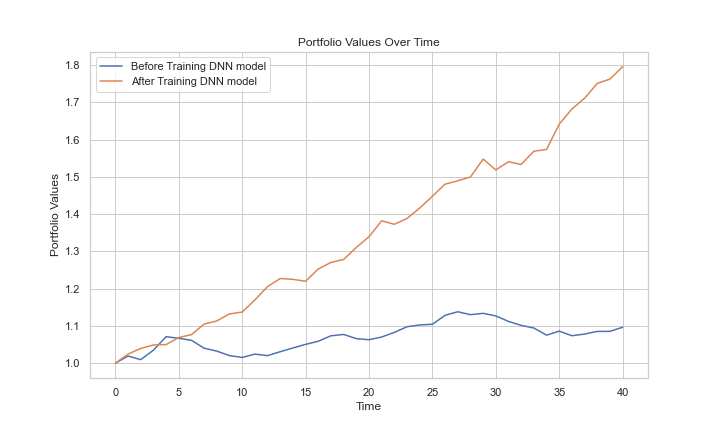

## Outsample Score
author use $V_0 = E[\phi(\eta,\hat{\Phi}]$ as outsample score to make comparison to LSMC and HJB solution

In J.Wang's Hamilton–Jacobi–Bellman (HJB) paper, he defined value function as $$ V_\tau = \inf_{p \in P} \left( \mu_w^p V_w + \frac{1}{2} (\sigma_w^p)^2 V_{ww} \right) $$ where $\tau$ = T - t and terminal condition is $V(w,\tau=0)=(W-\frac{\gamma}{2})^2$ 
 
In F.Cong's LSMC paper, he defined value function as $$ V_t(W_t) = L_t \left( W_t (R_f)^{\frac{T-t}{\delta t}} - \frac{\gamma}{2} \right)^2 $$ where  $$ L_t = \prod_{s=t}^{T} \left(1 - \frac{(E(R_{t}^{e}))^2}{(E(R_{t}^{e}))^2}\right) $$

terminal condition is $$ V_T(W_T) = (W_T - \frac{\gamma}{2})^2 $$

In our paper, terminal value function is $V_T(W_T) = (W_T - \frac{\gamma}{2})^2$, but author didn't explicitly define $V_t(W_t)$
I believe $$V_t(W_t) = (W_{t+1}(R_f)^\frac{-1}{\delta t} - \frac{\gamma}{2})^2 $$ becasue LSMC is going backward dynamic, but DNN is going forward dynamic.

if I used $V_t(W_t) = (W_{t+1}(R_f)^{\frac{-1}{\delta t}} - \frac{\gamma}{2})^2 $ equation, I get outsample score of 0.953. Author's outsample score is 0.829


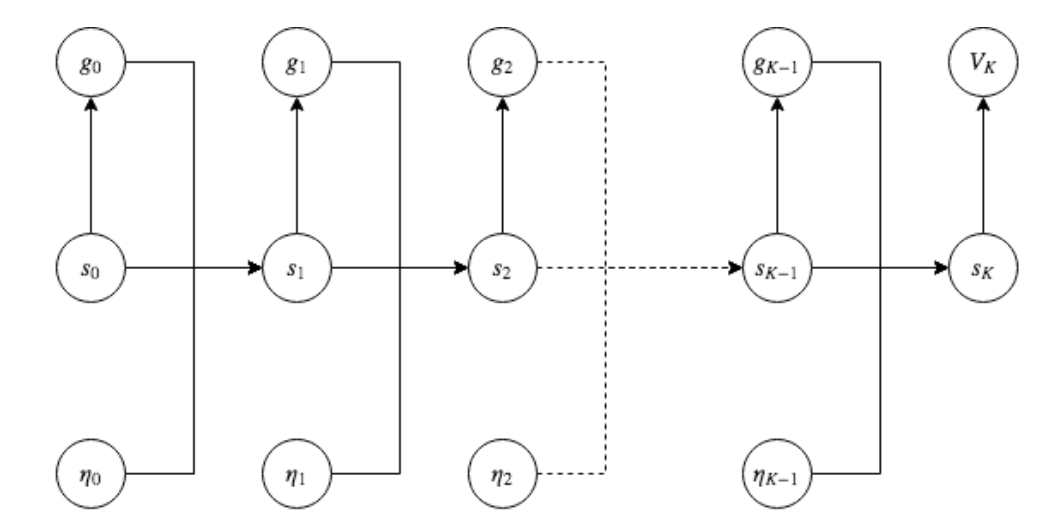

## Efficient Frontier for terminal wealth
$V_T(W_T) = (W_T - \frac{\gamma}{2})^2$, $\gamma$ is risk aversion
- Increase gamma: 
  - Increases mean of terminal wealth $W_T$
  - Increases standard deviation (risk) of terminal wealth

- Decrease gamma: 
  - Decreases mean of terminal wealth $W_T$
  - Decreases standard deviation (risk) of terminal wealth

So, by varying gamma value, you can construct an efficient frontier and find optimal balance between risk and return.

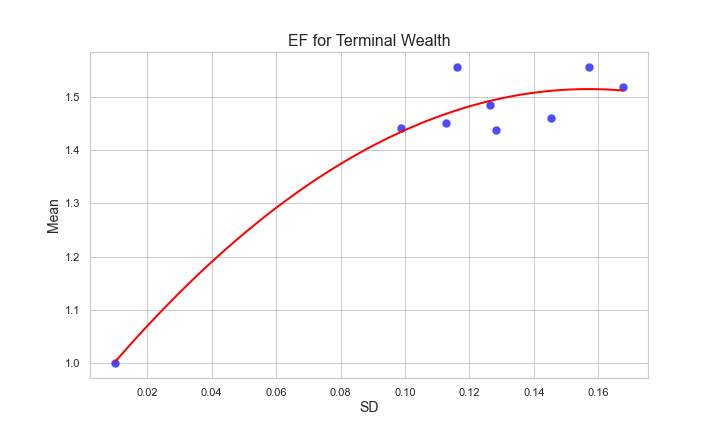

## AR(1) Model**: $R_k = \alpha + AR_{k-1} + \epsilon$

$s_k = (W_k, R_{k-1})$, $\eta_k = \epsilon_k$, $W_{k+1} = W_k(g_k^TR_k + R_f)$, and $s_{k+1} = (W_k(g_k^TR_k + R_f), R_k)$

In [43]:
!git clone https://github.com/Zhiwei2799/516-Code.git
%cd 516-Code
!python AR_main.py

Cloning into '516-Code'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 286 (delta 94), reused 132 (delta 81), pack-reused 132
Receiving objects: 100% (286/286), 298.24 KiB | 6.34 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/Users/zhiweilin/516-Code/516-Code
num_samples: 20000
self.batch_size: 64
### Training... ###
/Users/zhiweilin/516-Code/516-Code/ModelAR.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch_0 = torch.tensor(x_batch_0, dtype=torch.float32)
/Users/zhiweilin/516-Code/516-Code/ModelAR.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch_1 = to

## CCC-GARCH(1,1) MODEL:
$$
R_{k,i} = \mu_i + z_{k,i}
$$

$$
z_{k,i} = \Sigma_{k,i}\epsilon_{k,i}
$$

$$
\Sigma^2_{k+1,i} = \omega_{i} + \alpha_i\Sigma_{k,i}^2+\beta_i z_{k,i}^2, \quad i=1,....,p, \quad k=0,1,....,K-1
$$

$s_k = (W_k, \Sigma_{k}^2), \eta_k = z_k, R_k = \mu + \eta_k, \Sigma_{k+1,i}^2 = \omega_i + \alpha_i \Sigma_{k,i}^2 + \beta_i \eta_{k,i}^2$ $s_{k+1} =(W_k(g_k^TR_k + R_f), \Sigma_{k+1}^2) $

In [42]:
!python Garch_main.py  # it's fast becasue I only used 1000 simulation and hyperparamters are meaningless

### Training... ###
/Users/zhiweilin/516-Code/ModelGarch.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch_0 = torch.tensor(x_batch_0, dtype=torch.float32)
/Users/zhiweilin/516-Code/ModelGarch.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch_1 = torch.tensor(x_batch_1, dtype=torch.float32)
Epoch 1 Loss 1.898355 Duration 1.176 seconds.
Epoch 2 Loss 1.625228 Duration 0.835 seconds.
Epoch 3 Loss 1.510989 Duration 0.978 seconds.
Epoch 4 Loss 1.335906 Duration 0.905 seconds.
Epoch 5 Loss 1.274685 Duration 1.006 seconds.
Epoch 6 Loss 1.444308 Duration 0.891 seconds.
Epoch 7 Loss 1.141065 Duration 0.917 seconds.
Epoch 8 Loss 1.234013 Duration 1.031 seconds.
Epoch 9 Loss 1